# Siguiendo la lógica computacional

## El mismo problema, distintas miradas ... 

En el notebook anterior planteamos un problema de accesibilidad y lo trabajamos programáticamente con `Pandana`. Con ello, conseguimos construir una métrica de demanda a escuelas

# El formato GTFS 

Del inglés, "General Transit Feed Specification (GTFS)" hace referencia a un formato común para disponibilizar horarios de transporte público e información geográfica asociada como ubicación de paradas o recorridos.

Concretamente, se trata de una colección de (al menos) 6 archivos con información de las agencias de transporte, los recorridos, los viajes y su calendario, los tiempos de llegada y salida y las paradas. Pueden haber campos adicionales, pero estos son los más importantes.


<img src="https://www.researchgate.net/profile/Santi-Phithakkitnukoon/publication/319605381/figure/fig1/AS:551029546074112@1508387089346/Relations-among-different-text-files-of-a-GTFS-feed.pngsvg" width="45%" />

Este formato es verdaderamente útil para análisis de transporte multimodal o para combinar redes de tránsito con redes pedestres. 

En este notebook vamos a hacer algo de eso. Vamos a aprovechar la [API](https://apitransporte.buenosaires.gob.ar/console/) de transporte del Gobierno de la Ciudad e Buenos Aires para consultar los schedules de algunos medios de transporte.

Este servicio necesita un `client_id` y un `secret_id`. Ambos se pueden obtener fácilmente registrandose [acá](https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte)

In [1]:
# instalamos librerías
!pip install urbanaccess
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# montamos el drive para usar os. Si estás en Jupyter, esto no es necesario
from google.colab import drive
drive.mount('/drive/')

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


In [1]:
# importamos urbanaccess y os
import os
import urbanaccess
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.network import create_transit_net
from urbanaccess.osm.load import ua_network_from_bbox
from urbanaccess.osm.network import create_osm_net
from urbanaccess.network import integrate_network

Primero, creamos una función que nos permita trabajar con las fuentes GTFS de la Ciudad de Buenos Aires. 

El Gobierno de la Ciudad cuenta con una [API de transporte](https://apitransporte.buenosaires.gob.ar/) para consultar información sobre distintos medios de transporte. 

Para consumir este servicio es necesario que cuentes con un `client_id` y un `secret_id`. Ambos son enviados por mail una vez que te registrás como usuario de la API.

# Redes multimodales

Existen varias formas de construir redes de transporte. Una es a partir de conjuntos de archivos `GTFS`. [Urbanaccess](https://github.com/UDST/urbanaccess) es una librería de python que permite hacer justamente eso. 

Básicamente, reconstruye una red de servicios de transporte público a partir de sus horarios y esquemas de circulación. 
Tiene la virtud de poder combinar distintas agencias de tránsito en una sola red y, por lo tanto, trabajar con varios modos de transporte. 

Además, puede combinar redes pedestres consultadas desde OpenStreetMap.


In [31]:
def download_bsas_gtfsfeeds(vehicles=['default','bus']):
    '''
    Downloads GTFS feeds for subway or bus.
    '''
    for v in vehicles:
        if v == 'default':
            # Por defecto, urbanaccess encuentra el GTFS de subtes
            bsas_subte = gtfsfeeds.search(search_text='BuenosAires',
                                          search_field=None,
                                          match='contains',
                                          add_feed=False)
            url = bsas_subte['dataexchange_url'].values[0]+'latest_zip'
            key = 'BsAs_subte'
            feeds.add_feed(add_dict={key:url}) # agregamos la url 
            path = '/drive/MyDrive/Gestion de ciudades/data/BsAs_subte'
            os.mkdir(path) 
            gtfsfeeds.download(path) # para descargar su informacion en este directorio
            feeds.remove_feed(del_key=key)

        elif v == 'bus':
            # También podemos especificar otro medio de transporte
            # la URL contiene el client_id y el client secret
            url = 'https://apitransporte.buenosaires.gob.ar/colectivos/feed-gtfs-frequency?client_id=2ec875b51deb463580366bce70b04709&client_secret=b4b3e8717dee4C2C83dA1F744C68Cb78'
            key ='BsAs_colectivos'
            feeds.add_feed(add_dict={key:url})
            path = '/drive/MyDrive/Gestion de ciudades/data/BsAs_colectivos'
            os.mkdir(path)
            gtfsfeeds.download(path)
            feeds.remove_feed(del_key=key)
        else:
            raise ValueError("El medio de transporte indicado no ha sido especificado aún")

En una segunda instancia, vamos a necesitar cargar nuestro objeto de tránsito. Para ello, vamos a crear una función que cargue la información que descargamos previamente. 

El argumento bbox delimita un área de interés. Para crear un conjunto de coordenadas pueden recurrir a [esta]('https://boundingbox.klokantech.com/) herramienta que les indicará cuáles son las latitudes y longitudes del `bbox`.

In [75]:
def load_transit_object(data_path):
    '''
    Loads transit data object downloaded from GTFS source.
    '''
    validation = True
    verbose = True
    # BsAs bbox
    bbox = (-58.538328,-34.709952,-58.325468,-34.527999)
    remove_stops_outsidebbox = True
    append_definitions = True

    loaded_feeds = urbanaccess.gtfs.load.gtfsfeed_to_df(data_path,
                                                        validation,
                                                        verbose,
                                                        bbox,
                                                        remove_stops_outsidebbox,
                                                        append_definitions)
    return loaded_feeds

Por último, vamos a tener querer integrar la información que obtuvimos de la fuente GTFS con una red pedestre o de vehículos privados consultada a partir de la API de Open Sreet Map.

In [ ]:
def integrate_urbanaccess_network(transit_obj, day_name, timerange_list,
                                  travel_speed_int, osm_network_type,
                                  calculate_headways=False, metric=None):
    '''
    Creates an integrated GTFS transit + OSM drive|walk network. 
    '''
    # Instanciamos nuestra red de transito. Esto crea un objeto global de tipo UrbanAccess 
    transit_net = create_transit_net(gtfsfeeds_dfs=transit_obj,
                                     day=day_name,
                                     timerange=timerange_list)

    # Creamos nuestra OSM net
    bbox = (-58.538328,-34.709952,-58.325468,-34.527999)
    osm_nodes, osm_edges = ua_network_from_bbox(bbox=bbox)
    
    ua_network = create_osm_net(osm_edges=osm_edges,
                                osm_nodes=osm_nodes,
                                travel_speed_mph=travel_speed_int,
                                network_type=osm_network_type)
    # e integramos ambas
    urbanaccess_nw = integrate_network(urbanaccess_network=ua_network,
                                       headways=calculate_headways,
                                       headway_statistic=metric)
    return urbanaccess_nw

Con el método `create_transit_net` estamos creando una red o grafo de nodos y ejes para un momento específico de la semana. El objeto que se crea con este método tiene caracter global porque existe por fuera del scope de la función. Es por eso que, puede ser automáticamente llamado por el método `integrate_network`. Esa red que fue creada contiene información sobre las conexiones entre nodos. Un campo bastante universal con el que se trabaja es con el tiempo de viaje de estación a estación. Esto se obtiene desde la fuente GTFS y se utiliza para pesar las conexiones dentro de la red.

In [32]:
# Esta función nos va a crear un directorio donde se descargará la información consultada a la API
download_bsas_gtfsfeeds(vehicles=['bus'])

Added 1 feeds to gtfs_feeds: {'BsAs_colectivos': 'https://apitransporte.buenosaires.gob.ar/colectivos/feed-gtfs-frequency?client_id=2ec875b51deb463580366bce70b04709&client_secret=b4b3e8717dee4C2C83dA1F744C68Cb78'}
/drive/MyDrive/Gestion de ciudades/data/BsAs_colectivos/gtfsfeed_zips does not exist. Directory was created
1 GTFS feed(s) will be downloaded here: /drive/MyDrive/Gestion de ciudades/data/BsAs_colectivos/gtfsfeed_zips
BsAs_colectivos GTFS feed downloaded successfully. Took 43.42 seconds for 13,714,779.0KB
GTFS feed download completed. Took 43.43 seconds
/drive/MyDrive/Gestion de ciudades/data/BsAs_colectivos/gtfsfeed_text does not exist. Directory was created
BsAs_colectivos.zip successfully extracted to: /drive/MyDrive/Gestion de ciudades/data/BsAs_colectivos/gtfsfeed_text/BsAs_colectivos
GTFS feed zipfile extraction completed. Took 0.53 seconds for 1 files
Removed BsAs_colectivos feed from gtfs_feeds


In [33]:
# Cargamos el feed con la data en formato GTFS
data_path = '/drive/MyDrive/Gestion de ciudades/data/BsAs_colectivos/gtfsfeed_text'
transit_data = load_transit_object(data_path)

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.20 seconds
--------------------------------
Processing GTFS feed: BsAs_colectivos
GTFS feed: BsAs_colectivos, calendar_dates uses the same service_id across multiple agency_ids. This feed calendar_dates table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: BsAs_colectivos, calendar uses the same service_id across multiple agency_ids. This feed calendar table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: BsAs_colectivos, stops uses the same stop_id across multiple agency_ids. This feed stops table will be modified from its original format to provide stop_ids for each agency using a one to many join
agency.txt agency_name column has more than one agency name listed. Unique agency id was assign

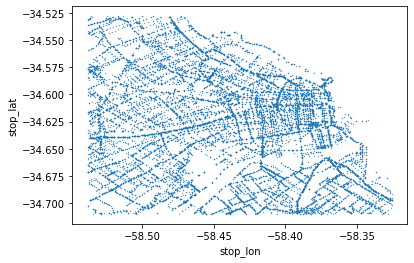

In [34]:
# El objeto transit data contiene información de la red de transito. Por ejemplo, las paradas del servicio
transit_data.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1);

Ahora sí, vamos a integrar nuestra red de tránsito con una red pedestre consultada a partir de OSM. Esto nos va a permitir trabajar conjuntamente con los nodos y ejes de las mismas. 


In [35]:
%time
urbanaccess_net = integrate_urbanaccess_network(transit_obj=transit_data, day_name='monday', 
                                                timerange_list=['01:00:00', '21:00:00'], 
                                                travel_speed_int=3, osm_network_type='walk',
                                                calculate_headways=False, metric=None)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.54 µs
Using calendar to extract service_ids to select trips.
139 service_ids were extracted from calendar
2,091 trip(s) 29.15 percent of 7,173 total trip records were found in calendar for GTFS feed(s): ['bsas colectivos']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
2,091 of 7,173 total trips were extracted representing calendar day: monday. Took 0.04 seconds
Note: Processing may take a long time depending on the number of records. Total unique trips to assess: 1,423
Starting departure stop time interpolation...
Departure time records missing f

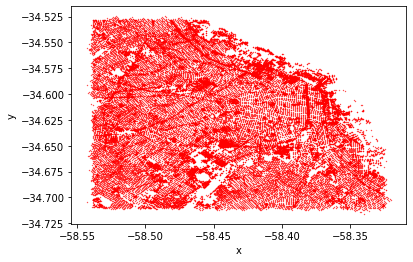

In [36]:
# Estos son los nodos de nuestra red pedestre
urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1, color='red');

La red integrada que creamos con Urbanaccess también puede ser usada para crear un nuevo objeto a partir de `pandana`. Si se fijan bien cómo se hace esto, verán que los argumentos de la clase `pdna.Network` son los nodos/ejes y la impedancia (el tiempo de viaje de los usuarios) de nuestra `urbanaccess_net`.

In [37]:
#!pip install pandana
import pandana as pdna

In [38]:
%time
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


Algo que se puede hacer con esto, es utilizar la red para estimar medidas de accesibilidad. Por ejemplo, la cantidad de escuelas accesibles en un rango de 15, 30 o 45 minutos a los nodos de nuestra red.

Para eso vamos a contar la cantidad de escuelas por radio censal y le vamos a asignar ese valor al nodo de la red que se encuentre más cerca del centroide del polígono (en nuestro caso, el radio censal).

Si recuerdan, la medida de impedancia que construimos es el tiempo de viaje de nodo a nodo (es decir, un atributo de los ejes). Lo que construimos con esto, es una métrica de [accesibilidad acumulativa](https://github.com/UDST/pandana/blob/dev/pandana/network.py#L400-L478).

Es decir, vamos incorporando cada vez más nodos a medida que ampliamos el umbral de tiempo. Es como si fueramos agregando cada vez más ejes al análisis.

# Accesibilidad a escuelas

Con esto, vamos a combinar `Urbanaccess` con `Pandana` para reconstruir la accesibilidad a escuelas alrededor de la red de transporte de la Ciudad de Buenos Aires. 

Para eso, vamos a empezar por contar la cantidad de escuelas para una división administrativa arbitraria. En lo posible la más granular que tengamos. Por ejemplo, radios censales.

In [39]:
import geopandas as gpd

In [40]:
escuelas = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/establecimientos-educativos/establecimientos_educativos_WGS84.geojson')

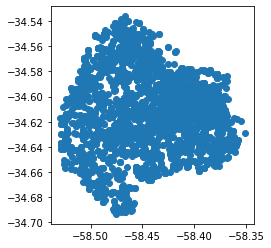

In [41]:
escuelas.plot();

In [42]:
path = '/drive/MyDrive/Gestion de ciudades/data/censo_2010/radios_rmba.geojson'
rmba = gpd.read_file(path)

In [43]:
caba = rmba.loc[rmba.link.apply(lambda x: x[:2]=='02')].copy().to_crs(4326)

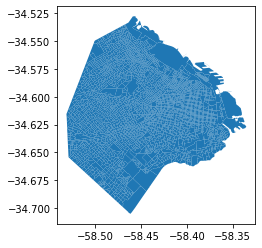

In [44]:
caba.plot();

In [45]:
# asignamos el id del radio a las escuelas
escuela_radio = gpd.sjoin(escuelas, caba[['link','geometry']], predicate='within')

In [46]:
# y contamos cuántas hay por radio
cant = escuela_radio.groupby('link').size()

In [47]:
caba['escuelas'] = caba.link.map(cant).fillna(0)

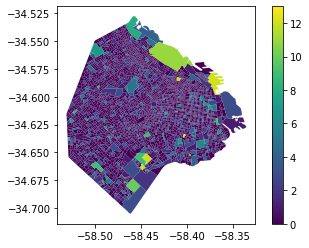

In [48]:
caba.plot(column='escuelas', legend=True, k=3);

In [49]:
import warnings
warnings.filterwarnings('ignore', message='Geometry is in a geographic CRS*')

In [50]:
# creamos coordenadas xy a partir del centroide del radio
caba['x'], caba['y'] = caba.geometry.centroid.x, caba.geometry.centroid.y 

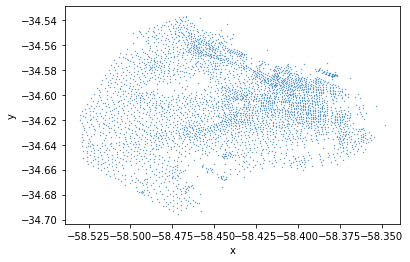

In [51]:
caba.plot(kind='scatter', x='x', y='y', s=0.1);

In [53]:
# Le asignamos el node_id al centroide más cercano para matchear nuestra métrica de accesibilidad
caba['node_id'] = transit_ped_net.get_node_ids(caba['x'], caba['y'])

In [54]:
transit_ped_net.set(caba.node_id, variable = caba.escuelas, name='escuelas')

Ahora sí, creamos nuestra métrica de accesibilidad: La cantidad de escuelas accesibles a 45, 30 y 15 minutos de viaje al nodo más cercano.

In [55]:
%time
escuelas_45 = transit_ped_net.aggregate(45, type='sum', decay='linear', name='escuelas')
escuelas_30 = transit_ped_net.aggregate(30, type='sum', decay='linear', name='escuelas')
escuelas_15 = transit_ped_net.aggregate(15, type='sum', decay='linear', name='escuelas')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


 Creemos una función para poder plotear estos resultados ...

In [56]:
import matplotlib.pyplot as plt

In [57]:
def plot_accesibility(var):
  fig = plt.subplots(figsize=(15,8))

  cm = plt.cm.get_cmap('gist_heat_r')

  x = transit_ped_net.nodes_df.x 
  y = transit_ped_net.nodes_df.y

  net_map = plt.scatter(x, y, c=var, s=4, cmap=cm)#edgecolor='none')

  plt.colorbar(net_map)
  plt.axis("off");

Y efectivamente vemos cómo a medida que aumentamos el tiempo de viaje al nodo más cercano, las intensidades crecen. Es decir, mayor cantidad de escuelas accesibles.

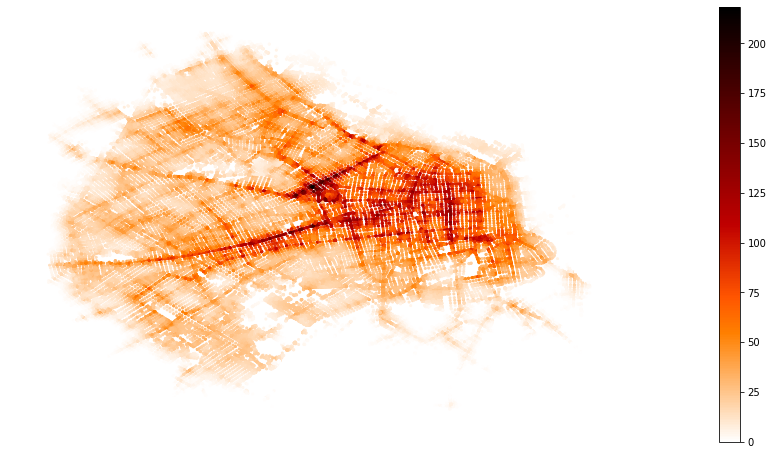

In [58]:
plot_accesibility(var=escuelas_15)

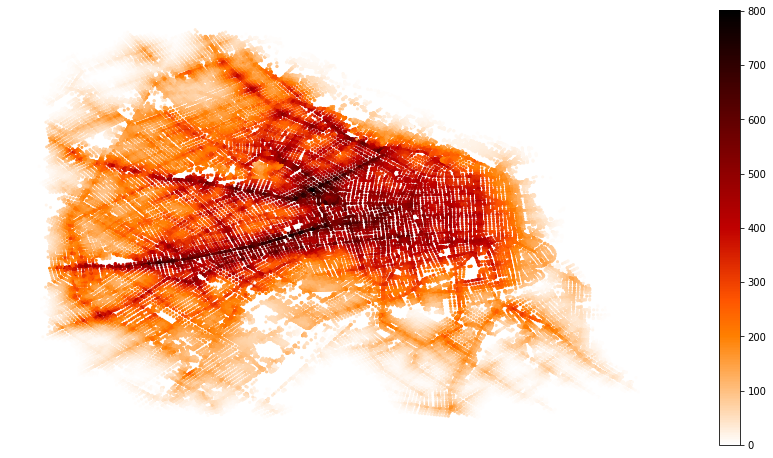

In [59]:
plot_accesibility(var=escuelas_30)

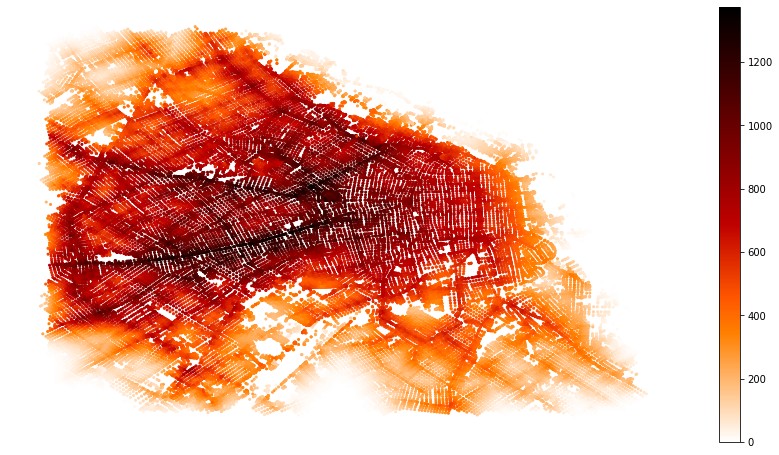

In [60]:
plot_accesibility(var=escuelas_45)

Por último, podemos ver que el output se encuentra un poco distorsionado en sentido horizontal. Esto es así, porque lo estamos ploteando son coordenadas en un plano xy. Pero, en rigor, esta no es aún información espacial en sí misma.
Para eso, deberíamos contar con una geometría con la que no contamos. 
Resivemos cómo se ven nuestras métricas de accesibilidad en un plano proyectado con coordenadas específicas.

In [ ]:
from shapely.geometry import Point

In [61]:
# creamos una geometría de puntos y le agregamos GKBsAs como sistema de coordenadas de proyección
proj = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'
xy_4326 = transit_ped_net.nodes_df.apply(lambda df: Point(df.x,df.y), axis=1).reset_index()
xy_4326.columns = ['id_int', 'geometry'] 
xy_gkbs = gpd.GeoDataFrame(xy_4326, geometry='geometry', crs=4326).to_crs(proj)
xy_gkbs.geometry.x

0        109064.799681
1        109064.799681
2        101166.076517
3         98678.430791
4        108825.395074
             ...      
60662    101453.289884
60663    101478.082540
60664    101477.650970
60665    101458.824263
60666    101456.547553
Length: 60667, dtype: float64

In [68]:
xy_gkbs['accesibility'] = xy_gkbs.index.map(escuelas_15.to_dict())

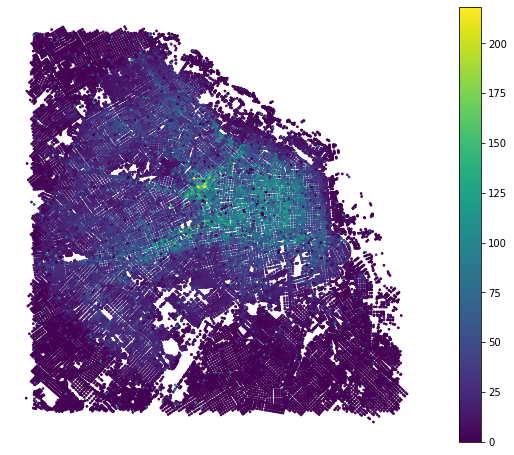

In [74]:
f, ax = plt.subplots(figsize=(12,8))
xy_gkbs.plot(column='accesibility', k=3, markersize=3, legend=True, ax=ax)
ax.set_axis_off();